<a href="https://colab.research.google.com/github/yalexie1/Data-Science/blob/main/Unit8/YaleXie_Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how much time you'll spend studying on a given day, using the amount of sleep you got the night before as a predictor.

If this seems to easy, then add another variable or two (test tomorrow? activity after school?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Answer1:**

Showed Arredondo.

**Task2**:

What is a decision tree? How do they work?

**Answer2:**

A binary decision tree is a type of graph where there are nodes that lead to other nodes via binary decisions (so each node has two branching children until the last ones which have no children). For numerical binary decision trees, each layer of the tree sorts the predictor values into subsets of the predicted values.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

**Answer3:**

The depth of a decision tree is how many layers it has. It helps control how well the curve fits the data (greater depth means a greater fit/greater pattern fitting). If a tree is too deep, it might capture too much variation in the data that was just noise. If it's not deep enough, it might not capture enough of the patterns in the data. In other words, too deep implies overfitting and not deep enough implies underfitting.

**Task4:**

How are BART models similar and different from a decision tree?

**Answer4:**

BART models use multiple decision trees in a random forest (RF). In this random forest, BART encourages the decision trees to be different from other trees to promote more diverse results from the random forest as a whole in a concept known as "boosting". This is when the BART model alters trees in the random forest based on other trees in the random forest so that they are different trees. Furthermore, BART models put regularizing priors on the depth of each decision tree, ensuring that the depth will be much less than the data points and that the model only explores near the data.

**Task5**:

Why would we use a BART model instead of a decision tree?

**Answer5:**

Decision trees trade accuracy for speed; they only calculate a pseudo-posterior mean and a pseudo-posterior predictive mean and they ignore variation for the sake of speed. They also are prone to underfitting and overfitting. BART models are slower than a single decision tree but they include variation and have measures to reduce underfitting (boosting) and overfitting (MCMC, regularizing priors).

## Bartian Penguins

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [2]:
!pip install pymc-bart

In [3]:
import pymc_bart as pmb

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [4]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()
penguins.head()

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.75,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.80,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.25,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.45,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.65,male,2007


In [9]:
clmn_list = ["species", "island", "bill_length", "bill_depth", "flipper_length", "body_mass", "sex", "year"]
peng_stats = penguins.loc[:,clmn_list].dropna()
peng_stats.head()

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.75,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.80,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.25,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.45,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.65,male,2007


In [10]:
X = peng_stats[["flipper_length", "bill_depth", "bill_length"]]
Y = peng_stats["body_mass"].to_numpy()

In [11]:
with pm.Model() as model_pengs:
    s = pm.HalfNormal('s', 10)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Normal("y", mu=μ, sigma=s, observed=Y)
    idata_pengs = pm.sample(compute_convergence_checks=False)

Output()

Output()

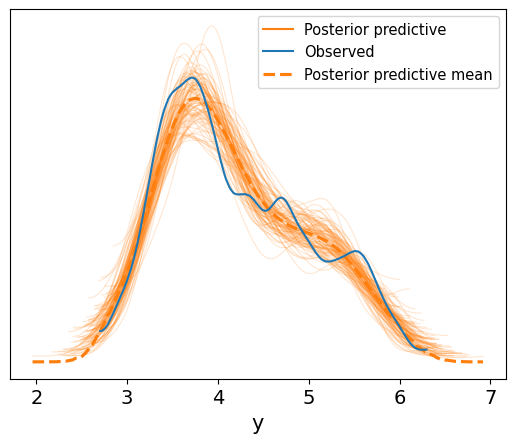

In [12]:
pm.sample_posterior_predictive(idata_pengs,model_pengs, extend_inferencedata=True)
ax = az.plot_ppc(idata_pengs, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

<Axes: xlabel='flipper_length', ylabel='body_mass'>

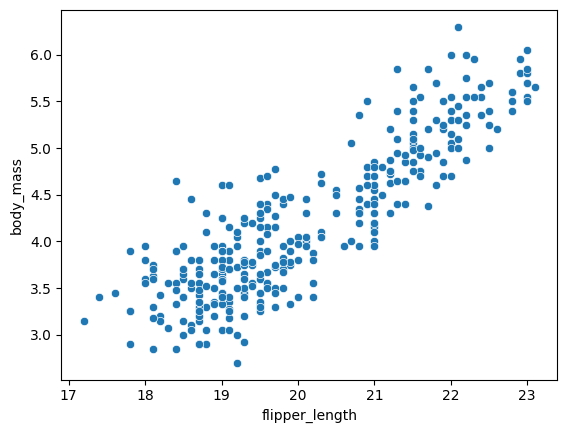

In [20]:
sns.scatterplot(data = peng_stats, y = 'body_mass', x = 'flipper_length')

In [16]:
posterior_mean = idata_pengs.posterior["μ"]

μ_hdi = az.hdi(ary=idata_pengs, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_pengs, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


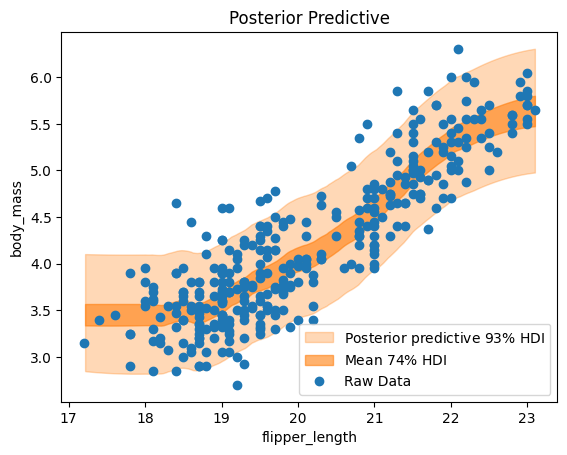

In [21]:
idx = np.argsort(X.to_numpy()[:, 0]) #grab first row
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.to_numpy()[:, 0],#grab first row
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X.to_numpy()[:, 0],#grab first row
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(peng_stats['flipper_length'], peng_stats["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper_length",
    ylabel="body_mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

**Answer8:**

Yes, I think the above plot makes sense and captures the true association between flipper length and body mass in penguins. For one, it captures the general **upwards trend** and **flattening out** very well. It **does not overfit** the data, as it ignores some of the outlying data points that don't need to be fitted to.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='bill_length'>], dtype=object)

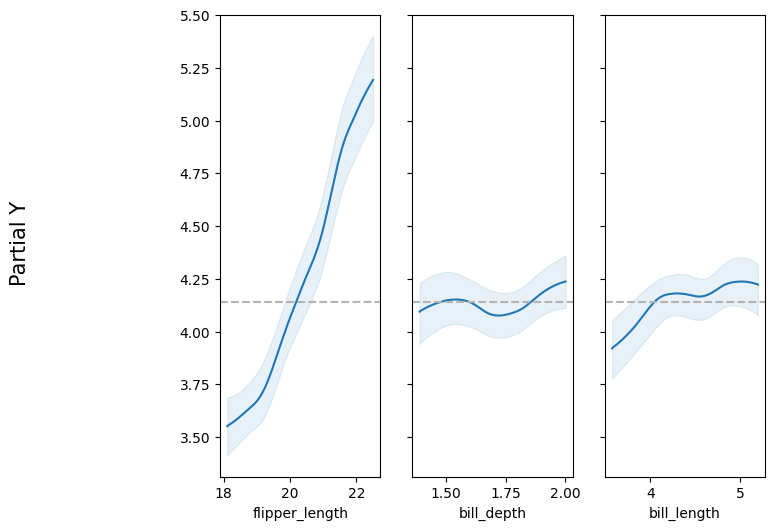

In [22]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='bill_length'>], dtype=object)

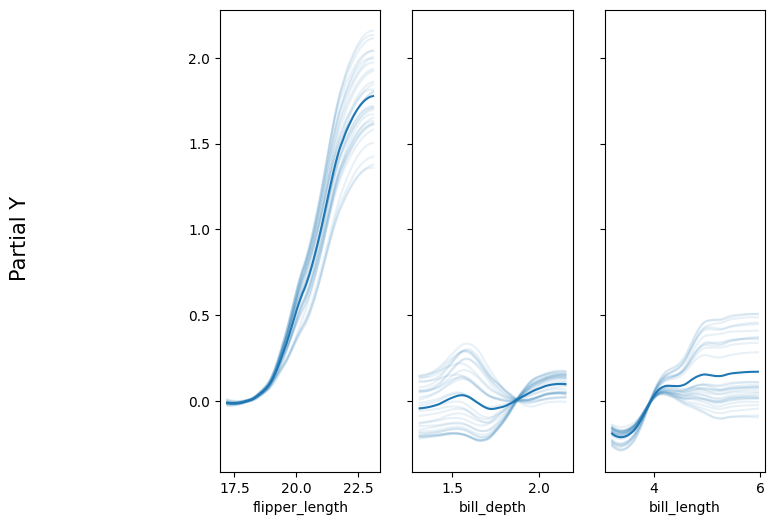

In [23]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

<Axes: ylabel='R²'>

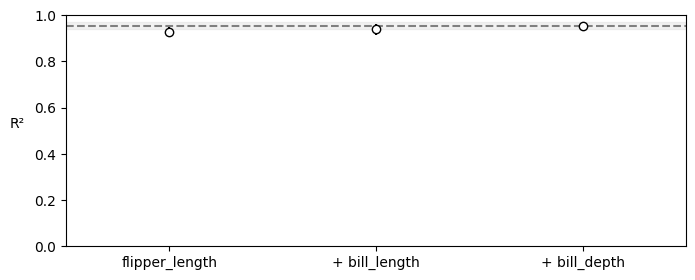

In [24]:
vi_pengs = pmb.compute_variable_importance(idata_pengs, μ_, X)
pmb.plot_variable_importance(vi_pengs)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

flipper_length is by far the most significant variable in predicting body mass in penguins. Looking at the variable independent plot, adding bill_length and bill_depth makes virtually no difference to R^2 since flipper_length *single-handedly* raised it to around 0.95. This can also be seen in the partial dependence and individual conditional plots (PDP and ICE). While flipper_length has an obvious correlation with body mass(it's practically linear), the other two variables look like waves and don't have an obvious linear correlation. As for relationships *between variables*, at high values, flipper_length definitely has some correlation with the other variables, as seen in the massively varying ICE plot. The same can be said for low bill_depth and high bill_length.